In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
from matplotlib import pyplot as plt

from module.base.network import Network

from module.simulation.meanfield import MeanField
from module.simulation.quick_meanfield2 import QuickMeanField2
from module.simulation.meanfield2 import MeanField2
from module.simulation.set_meanfield2 import SetMeanField2

import module.components.CONST as CONST
from module.components.lawrence_dist import LawrenceDist

from module.components.Adam import Adam

In [2]:
net = Network(10,10,1,[[0,0,0],[9,0,0],[0,9,0],[9,9,0]])
net.set_voltage_config([-3.302944822433594996e-01, -1.300645682722810503e-01, 2.974199217486594438e-01, -1.754745629759278669e-01], 1.307111545318153378e-01)
mf2 = QuickMeanField2(net)

In [6]:
mf2.ADAM_solve(N = 80, learning_rate = 0.1, reset=True)
mf2.ADAM_solve(N = 80, learning_rate = 0.005, reset=False, verbose = True)

ADAM convergence: (0.2463721840142215, 0.37371583274862175)


In [7]:
mf2.calc_derivatives()

(array([-1.31088592e-01, -2.34881400e-02,  9.07598751e-03,  1.10400571e-02,
        -7.31402897e-03, -4.11891236e-03, -3.02916583e-03,  3.03561656e-03,
        -1.63982392e-02, -6.32659194e-02, -2.81174687e-02,  1.69459371e-02,
        -6.89702937e-04, -1.29571953e-02, -1.31923956e-02, -2.11840894e-02,
        -2.18102658e-03,  1.15233788e-03, -3.38675766e-03, -8.34751712e-03,
         1.48269871e-04, -5.05515930e-03, -6.69138688e-02, -1.67116545e-02,
        -2.72769333e-02, -2.88347761e-02, -1.44603175e-02,  9.51946738e-03,
        -2.59971004e-02, -2.94391467e-03,  2.15138469e-03,  1.15009623e-01,
        -1.57820699e-01,  1.21154692e-01,  2.35157509e-02,  2.21818807e-02,
         1.09500963e-02, -4.82271782e-02,  1.04940564e-01, -5.09897778e-02,
        -1.02064241e-02, -6.89597296e-03, -6.84544812e-02, -1.06941496e-02,
         3.97214550e-02, -1.95278454e-03, -1.35834925e-02,  1.73521695e-04,
        -5.98373827e-02,  7.12008333e-02, -5.38047722e-03, -6.24394211e-03,
        -7.3

In [8]:
-mf2.calc_expected_electrode_current(3)

1.1706973652643162

In [9]:
mf = MeanField(net)
state = mf.numeric_integration_solve(N = 300, verbose = True)
print(mf.calc_expected_electrode_rates(state, 3) * CONST.electron_charge)

convergence: 0.021824623860795103
-1.0758390072625315


---
## Detail

In [44]:
net = Network(10,10,1,[[0,0,0],[9,0,0],[0,9,0],[9,9,0]])
net.set_voltage_config([-0.06,0,0.04,0.02],0)
net.set_voltage_config([-3.302944822433594996e-01, -1.300645682722810503e-01, 2.974199217486594438e-01, -1.754745629759278669e-01], 1.307111545318153378e-01)
mf2 = QuickMeanField2(net)
opt = Adam([mf2.means, mf2.vars])

In [54]:
N = 60
means = np.zeros((2*N, 100))
vars = np.zeros((2*N, 100))
convs_means = np.zeros(2*N)
convs_vars = np.zeros(2*N)

for i in range(N):
    means[i] = mf2.means
    vars[i] = mf2.vars

    mm, vv = mf2.convergence_metric()
    convs_means[i] = mm
    convs_vars[i] = vv
    
    dmean, dvar = opt.calc_step(mf2.calc_derivatives(), learning_rate = 0.1)
    mf2.means += dmean
    mf2.vars += dvar
    mf2.clip_vars()

print("intense")

for i in range(N, 2*N):
    means[i] = mf2.means
    vars[i] = mf2.vars

    mm, vv = mf2.convergence_metric()
    convs_means[i] = mm
    convs_vars[i] = vv
    
    dmean, dvar = opt.calc_step(mf2.calc_derivatives(), learning_rate = 0.005)
    mf2.means += dmean
    mf2.vars += dvar
    mf2.clip_vars()

intense


In [55]:
mf2.convergence_metric()

(0.18884537487681258, 0.21882386229153516)

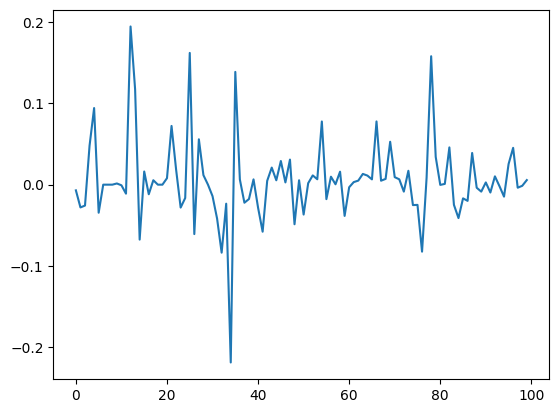

In [56]:
plt.plot(mf2.calc_derivatives()[1])

In [57]:
np.argmax(np.abs(mf2.calc_derivatives()[1]))

34

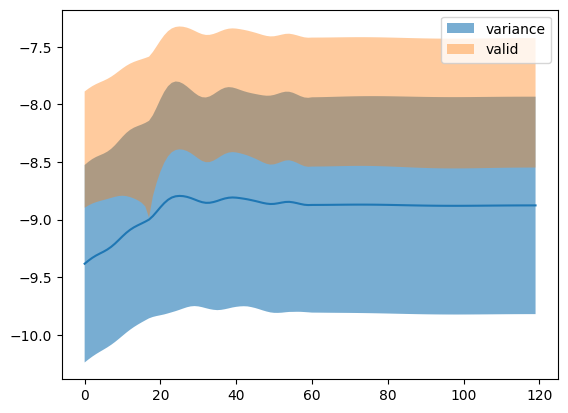

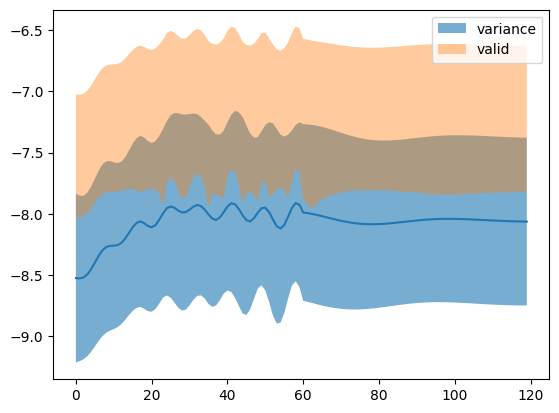

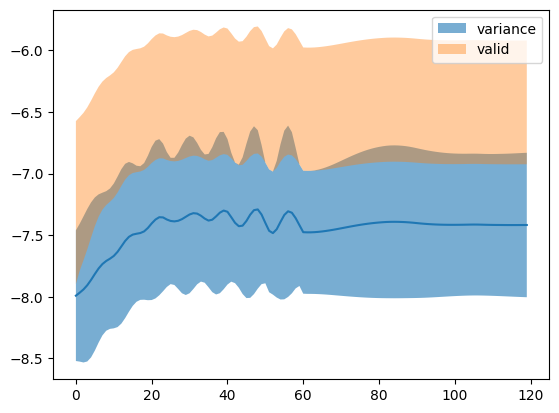

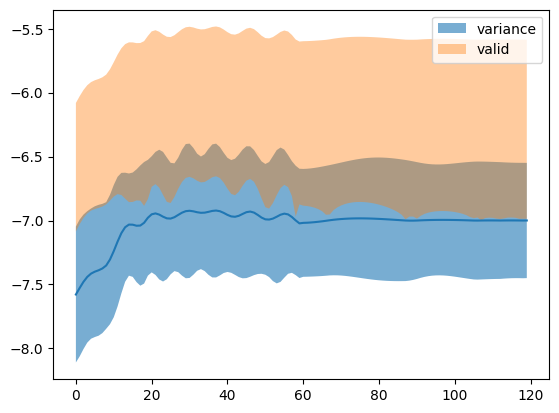

In [58]:
for i in range(1,5):
    plt.figure()
    d = means[:,i] - np.floor(means[:,i])
    plt.plot(np.arange(2*N), means[:,i])
    plt.fill_between(np.arange(2*N), means[:,i] - np.sqrt(vars[:,i]),  means[:,i] + np.sqrt(vars[:,i]), alpha = 0.6, label = "variance")
    plt.fill_between(np.arange(2*N), means[:,i] + np.sqrt(d * (1-d)),  means[:,i] + np.sqrt((2-d) * (1+d)), alpha = 0.4, label = "valid")
    plt.legend()

In [59]:
np.mean(np.abs(opt.V[0]))

0.012299570413460671

In [60]:
np.mean(np.abs(opt.V[1]))

0.027041633986810355

In [65]:
mf = MeanField(net)
mf_mean = mf.numeric_integration_solve(verbose = True, N = 250)

convergence: 0.03967337525299797


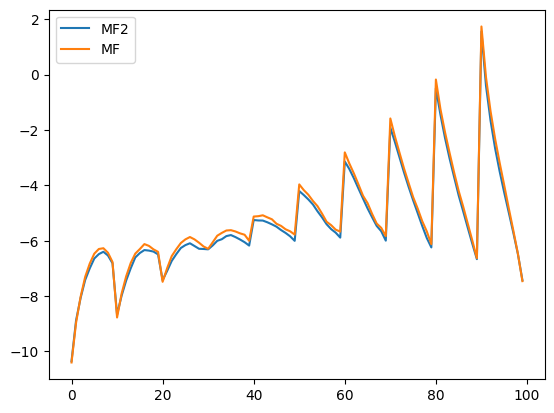

In [67]:
plt.plot(mf2.means, label = "MF2")
plt.plot(mf_mean, label = "MF")
plt.legend()